# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Общие данные

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import time

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переведем названия столбцов в общепринятый формат

In [5]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
      'last_seen']

In [6]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Обработка признаков

**Начнем с удаления неинформативных признаков**

Рассмотрим дату создания анкеты и последнюю активность пользователя

In [8]:
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')

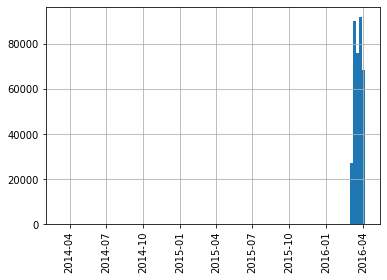

In [9]:
df['date_created'].hist(bins=100)
plt.xticks(rotation=90)
plt.show()

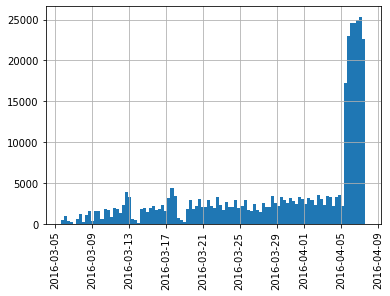

In [10]:
df['last_seen'].hist(bins=100)
plt.xticks(rotation=90)
plt.show()

Из гистограмм видно, что большинство анкет создано в марте-апреле 2016 года, но есть небольшое количесвто анкет, созданных в период 2014-2016 гг. Можно было бы предположить, что информация в этих анкетах потеряла свою актуальность. Но так как дата последней активности пользователей находится в диапазоне март-апрель 2016 года, все анкеты должны быть одинаково актуальны. Исключим эти признаки из выборки, как не несущие полезной информации. Также на стоимость автомобиля не могут влиять дата выгрузки анкеты, месяц регистрации автомобиля, почтовый индекс владельца анкеты

In [11]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'registration_month', 'postal_code'], axis=1)

**Стоимость (целевой признак)**

<AxesSubplot:>

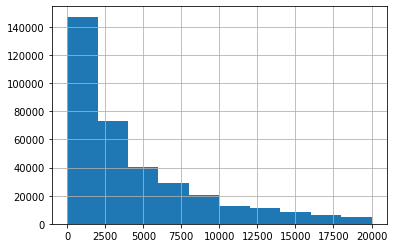

In [12]:
df.price.hist()

In [13]:
print('Количество объявлений, у которых стоимость автомобиля равна 0:', len(df.query('price==0')))

Количество объявлений, у которых стоимость автомобиля равна 0: 10772


Объявления, у которых отсутствует целевой признак, не подходят для обучения модели. Исключим эти объекты из выборки.

In [14]:
df = df.query('price!=0')

**Тип кузова, коробка передач, модель, тип топлива**

Заменим пропуске в столбцах с типом кузова, коробкой передач, моделью, типом топлива на dummy-значение 'unknown':

In [15]:
df[['vehicle_type', 'gearbox', 'model', 'fuel_type']] = df[['vehicle_type', 'gearbox', 'model', 'fuel_type']].fillna('unknown')

**Ремонтированные автомобили**

In [16]:
df.not_repaired.value_counts(normalize=True)

no     0.877403
yes    0.122597
Name: not_repaired, dtype: float64

Среди тех объявлений, где указано, ремонтировалась ли машина, всего лишь 12% автомобилей не были в ремонте. Среди объявлений, где это этот признак не указан, вероятно, такое же превалирование ремонтированных машин. Заменим пропуски на 'no'.

In [17]:
df.not_repaired = df.not_repaired.fillna('no')

**Год регистрации**

<AxesSubplot:>

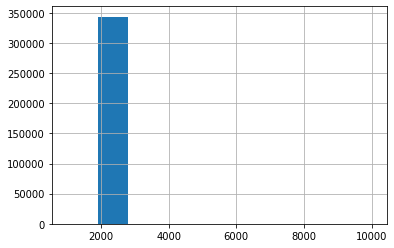

In [18]:
df['registration_year'].hist()

Видно, что значения года регистрации находятся в диапазоне  от 0 до 10000, что указывает на наличие некорректных значений

<AxesSubplot:>

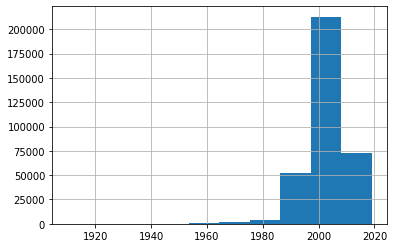

In [19]:
df[(df['registration_year'] < 2030) & (df['registration_year'] > 1900)]['registration_year'].hist()

Предположим, что в объявлениях действительно есть раритетные автомобили до 1940 года выпуска. Дату в объявлениях раньше 1940 или позже 2020 заменим на dummy-значение 0.

In [20]:
def change_date(row):
    if (row['registration_year'] < 1940) or (row['registration_year'] > 2020):
        return 0
    else:
        return row['registration_year']

In [21]:
df['registration_year'] = df.apply(change_date, axis=1)

**Количество фотографий**

In [22]:
df.number_of_pictures.value_counts()

0    343597
Name: number_of_pictures, dtype: int64

У каждого объявления указано нулевое количество фотографий. Удалим этот признак как неинформативный

In [23]:
df = df.drop(['number_of_pictures'], axis=1)

**Мощность**

<AxesSubplot:>

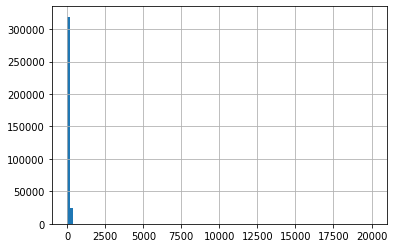

In [24]:
df.power.hist(bins=100)

Видно, что имеется большое количество выбросов. 

In [25]:
print('0.1% наибольших значений мощности принимает значения выше', df.power.quantile(.999))
df[df['power'] > df.power.quantile(.999)]

0.1% наибольших значений мощности принимает значения выше 620.0


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,no
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,no
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,unknown,2017,manual,2000,other,60000,gasoline,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,no


Заменим выбросы, находящиеся в диапазоне выше 0.999 квантили, и нулевые значения на медианное значение

In [26]:
power_median = df.power.median()
power_quantile = df.power.quantile(.999)

In [27]:
def change_power(row):
    if (row['power'] > power_quantile) or (row['power'] == 0):
        return power_median
    else:
        return row['power']

In [28]:
df['power'] = df.apply(change_power, axis=1)

<AxesSubplot:>

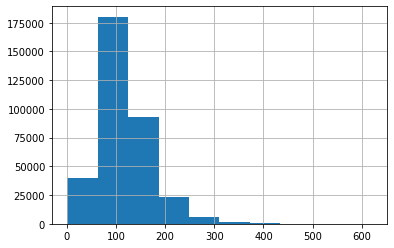

In [29]:
df.power.hist()

Теперь заменим тип данных на целочисленные

In [30]:
df['power'] = df['power'].astype(int)

**Датафрейм готов для дальнейшего обучения моделей.**

## Обучение моделей

### Линейная регрессия

Преобразуем категориальные переменные в численные методом One-Hot Encoding

In [31]:
df_ohe = pd.get_dummies(df, drop_first=True)

Поделим данные на обучающую и тестовую выборки в отношении 4:1.

In [32]:
features = df_ohe.drop('price', axis=1)
target = df_ohe['price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=1)

Масштабируем численные признаки

In [33]:
numbers = ['registration_year', 'power', 'kilometer']

In [34]:
features_train_scaled = features_train
features_test_scaled = features_test

scaler = StandardScaler()
scaler.fit(features_train_scaled[numbers])
pd.options.mode.chained_assignment = None

features_train_scaled[numbers] = scaler.transform(features_train_scaled[numbers])
features_test_scaled[numbers] = scaler.transform(features_test_scaled[numbers])

In [35]:
%%time
model = LinearRegression()
fit_time_start = time.time()
model.fit(features_train_scaled, target_train)
fit_time_end = time.time()
rmse_linear = sqrt(mean_squared_error(target_test, model.predict(features_test_scaled)))
predict_time_end = time.time()
print('RMSE работы линейной модели на тестовой выборке:', rmse_linear)

RMSE работы линейной модели на тестовой выборке: 2899.6603975295816
CPU times: user 18 s, sys: 6.78 s, total: 24.7 s
Wall time: 24.7 s


Сохраним время обучения и предсказания в переменных

In [36]:
linear_fit_time = fit_time_end - fit_time_start
linear_pred_time = predict_time_end - fit_time_end

### Дерево решений

In [37]:
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [38]:
%%time
model = DecisionTreeRegressor(random_state=1)
parametrs = {'max_depth': range (5, 21, 5),}
grid_tree = GridSearchCV(model, param_grid=parametrs, cv=5, scoring=rmse_scorer)
fit_time_start = time.time()
grid_tree.fit(features_train, target_train)
fit_time_end = time.time()
rmse_tree = rmse(target_test, grid_tree.best_estimator_.predict(features_test))
predict_time_end = time.time()
print('RMSE работы дерева решений на тестовой выборке:', rmse_tree)
print('Максимальная глубина дерева наилучшей модели:', grid_tree.best_params_['max_depth'])

RMSE работы дерева решений на тестовой выборке: 1894.2314288959637
Максимальная глубина дерева наилучшей модели: 20
CPU times: user 1min 45s, sys: 6.88 s, total: 1min 52s
Wall time: 1min 52s


In [39]:
tree_fit_time = fit_time_end - fit_time_start
tree_pred_time = predict_time_end - fit_time_end

### Случайный лес

In [40]:
%%time
model = RandomForestRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'max_depth': [1, 10, 20],}
grid_forest = GridSearchCV(model, param_grid=parametrs, cv=5, scoring=rmse_scorer)
fit_time_start = time.time()
grid_forest.fit(features_train, target_train)
fit_time_end = time.time()
rmse_forest = rmse(target_test, grid_forest.best_estimator_.predict(features_test))
predict_time_end = time.time()
print('RMSE работы случайного леса на тестовой выборке:', rmse_forest)
print('Максимальная глубина дерева наилучшей модели:', grid_forest.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_forest.best_params_['n_estimators'])

RMSE работы случайного леса на тестовой выборке: 1664.5948617367865
Максимальная глубина дерева наилучшей модели: 20
Количество деревьев в наилучшей модели: 100
CPU times: user 1h 46min 48s, sys: 42.4 s, total: 1h 47min 31s
Wall time: 1h 47min 33s


In [41]:
forest_fit_time = fit_time_end - fit_time_start
forest_pred_time = predict_time_end - fit_time_end

### CatBoost

Для модели CatBoost необязательно перобразовывать категориальные признаки. Поделим исходный датафрейм на обучающую и тестовую выборки без преобразования категориальных признаков

In [42]:
features_cb = df.drop('price', axis=1)
target_cb = df['price']

features_cb_train, features_cb_test, target_cb_train, target_cb_test = train_test_split(
    features_cb, target_cb, test_size=.2, random_state=1)

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [43]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=1, verbose=0)
grid_cb = {'iterations': [10, 50, 100],
        'learning_rate': [0.03, 0.1],
        'depth': [1, 10, 15]}


train_cb = Pool(features_cb_train, target_cb_train, cat_features=cat_features) 

fit_time_start = time.time()
model_cb.grid_search(grid_cb, train_cb, verbose=0)
fit_time_end = time.time()
rmse_cb = rmse(target_cb_test, model_cb.predict(features_cb_test))
predict_time_end = time.time()
print('RMSE работы CatBoost на тестовой выборке:', rmse_cb)


bestTest = 5392.872473
bestIteration = 9


bestTest = 4054.606582
bestIteration = 9


bestTest = 3678.336177
bestIteration = 49


bestTest = 2817.766068
bestIteration = 49


bestTest = 3168.142066
bestIteration = 99


bestTest = 2490.181424
bestIteration = 99


bestTest = 5034.78965
bestIteration = 9


bestTest = 3124.249372
bestIteration = 9


bestTest = 2577.396231
bestIteration = 49


bestTest = 1827.354859
bestIteration = 49


bestTest = 1966.874043
bestIteration = 99


bestTest = 1748.759767
bestIteration = 99


bestTest = 5013.996403
bestIteration = 9


bestTest = 3077.885954
bestIteration = 9


bestTest = 2512.731692
bestIteration = 49


bestTest = 1736.813713
bestIteration = 49


bestTest = 1882.159905
bestIteration = 99


bestTest = 1674.107474
bestIteration = 99

Training on fold [0/3]

bestTest = 1690.61481
bestIteration = 99

Training on fold [1/3]

bestTest = 1692.877014
bestIteration = 99

Training on fold [2/3]

bestTest = 1684.234709
bestIteration = 99

RMSE работы Cat

In [44]:
cb_fit_time = fit_time_end - fit_time_start
cb_pred_time = predict_time_end - fit_time_end

### LightGBM

Для работы модели LightGBM нужно преобразовать тип данных категориальных признаков

In [45]:
features_cb_train[cat_features] = features_cb_train[cat_features].astype('category')
features_cb_test[cat_features] = features_cb_test[cat_features].astype('category')

In [46]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=rmse_scorer)
fit_time_start = time.time()
grid_lgb.fit(features_cb_train, target_cb_train)
fit_time_end = time.time()
rmse_lgb = rmse(target_cb_test, grid_lgb.best_estimator_.predict(features_cb_test))
predict_time_end = time.time()

print('RMSE работы модели LightGBM на тестовой выборке:', rmse_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

RMSE работы модели LightGBM на тестовой выборке: 1697.690213337172
Максимальная глубина дерева наилучшей модели: 15
Количество деревьев в наилучшей модели: 100
Коэффициент скорости обучения в наилучшей модели: 0.1
CPU times: user 5min 41s, sys: 1.89 s, total: 5min 43s
Wall time: 5min 45s


In [47]:
lgb_fit_time = fit_time_end - fit_time_start
lgb_pred_time = predict_time_end - fit_time_end

## Анализ моделей

In [48]:
results = pd.DataFrame({'Models':['Linear Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'LightGBM'],
                       'RMSE': [rmse_linear, rmse_tree, rmse_forest, rmse_cb, rmse_lgb],
                       'Fit time': [linear_fit_time, tree_fit_time, forest_fit_time, cb_fit_time, lgb_fit_time],
                       'Predict time': [linear_pred_time, tree_pred_time, forest_pred_time, cb_pred_time, lgb_pred_time]})

In [49]:
display(results)

,Models,RMSE,Fit time,Predict time
0,Linear Regression,2899.660398,24.533291,0.198764
1,Decision Tree,1894.231429,112.360891,0.134045
2,Random Forest,1664.594862,6451.674602,2.138469
3,CatBoost,1667.381048,498.580448,0.147311
4,LightGBM,1697.690213,344.876176,0.801326


**Анализ работы моделей показал, что при схожих гиперпараметрах наибольшая точность у моделей случайного леса и градиентного бустинга (CatBoost, LightGBM). При этом модели градиентного бустинга обучаются существенно быстрее модели случайного леса, а скорость обучение LightGBM выше скорости обучения CatBoost в 1,5 раза. Наивысшая скорость обучения у модели линейной регрессии - менее минуты, но такая скорость компенсируется низкой точностью прогнозов.**